In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.qc import *
sns.set_theme(font_scale=1.5)
from tqdm import tqdm

### $J = 1$

In [2]:
def Hamiltonian(v):    
    # qb = One_qubit()
    # H = 0.5*(np.kron(qb.Z, qb.I) + np.kron(qb.I, qb.Z)) - \
    #     v/2 * (np.kron(qb.X, qb.X) - np.kron(qb.Y, qb.Y))
    H = np.array([[1, 0, -v], [0, 0, 0], [-v, 0, -1]])
    return H

v_vals_ana = np.arange(0, 2, 0.01)
eigvals_ana = np.zeros((len(v_vals_ana), 3))
entropy = np.zeros((len(v_vals_ana), 3))
for index, v in enumerate(v_vals_ana):
    H = Hamiltonian(v)
    eigen, eigvecs = np.linalg.eig(H)
    permute = eigen.argsort()
    eigvals_ana[index] = eigen[permute]
    eigvecs = eigvecs[:,permute]

In [3]:
def prepare_state(theta0, phi0, theta1, phi1, target = None):
    qubit = Two_qubit()
    qubit.set_state([1, 0, 0, 0])
    qubit.rotate_x(theta0, 0)
    qubit.rotate_y(phi0, 0)
    qubit.rotate_x(theta1, 1)
    qubit.rotate_y(phi1, 1)
    qubit.apply_cnot01() # entangle the two qubits
    if target is not None:
        qubit.state = target
    return qubit.state

def get_energy(angles, v, number_shots, target = None):
    theta0, phi0, theta1, phi1 = angles
    
    init_state = prepare_state(theta0, phi0, theta1, phi1, target)
    qubit = Two_qubit()

    ZI = np.kron(qubit.Z, qubit.I)

    qubit.set_state(init_state)
    qubit.apply_swap() # rotate measurement basis
    measure_iz = qubit.measure(number_shots)

    qubit.set_state(init_state)
    measure_zi = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_hadamard(0)
    qubit.apply_hadamard(1)
    qubit.apply_cnot10() # rotate measurement basis
    measure_xx = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_sdag(0)
    qubit.apply_hadamard(0)
    qubit.apply_sdag(1)
    qubit.apply_hadamard(1)
    qubit.apply_cnot10() # rotate measurement basis
    measure_yy = qubit.measure(number_shots)
    

    # expected value of ZI = (#00 + #01 - #10 - #11)/ number of shots
    exp_vals = np.zeros(4) # do not include the expectation value of II
    measures = np.array([measure_iz, measure_zi, measure_xx, measure_yy])
    constants = np.array([1/2, 1/2, -v/2, v/2])
    for index in range(len(exp_vals)):
        counts = [len(np.where(measures[index] == i)[0]) for i in range(4)]
        exp_vals[index] = counts[0] + counts[1] - counts[2] - counts[3]

    exp_val = np.sum(constants * exp_vals) / number_shots
    return exp_val


In [4]:
from scipy.optimize import minimize
number_shots = 10_000
v_vals = np.linspace(0.0, 2.0, 10)
min_energy_scipy = np.zeros(len(v_vals))
for index, v in enumerate(tqdm(v_vals)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    res = minimize(get_energy, angles_start, args = (v, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_scipy[index] = res.fun
    # print(res.message)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.92it/s]


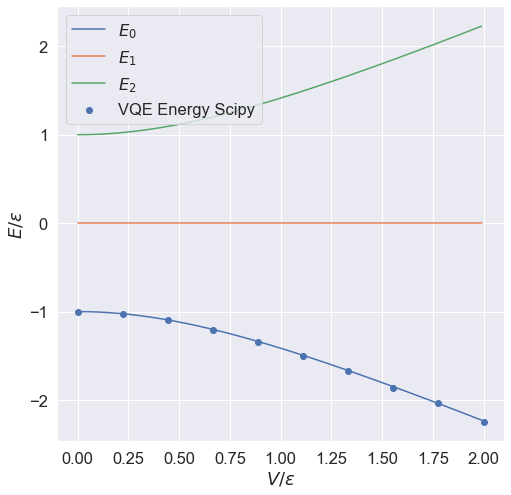

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(len(eigvals_ana[0])):
    axs.plot(v_vals_ana, eigvals_ana[:, i], label=f'$E_{i}$')
axs.set_xlabel(r'$V/\epsilon$')
axs.scatter(v_vals, min_energy_scipy, label='VQE Energy Scipy', marker='o')
axs.set_ylabel(r'$E/\epsilon$')
axs.legend(loc = 'upper left')
plt.show()

## J = 2

In [5]:
def Hamiltonian(v):    
    qb = One_qubit()
    ZIII = np.kron(qb.Z, np.kron(qb.I, np.kron(qb.I, qb.I)))
    IZII = np.kron(qb.I, np.kron(qb.Z, np.kron(qb.I, qb.I)))
    IIZI = np.kron(qb.I, np.kron(qb.I, np.kron(qb.Z, qb.I)))
    IIIZ = np.kron(qb.I, np.kron(qb.I, np.kron(qb.I, qb.Z)))

    XXII = np.kron(qb.X, np.kron(qb.X, np.kron(qb.I, qb.I)))
    XIXI = np.kron(qb.X, np.kron(qb.I, np.kron(qb.X, qb.I)))
    XIIX = np.kron(qb.X, np.kron(qb.I, np.kron(qb.I, qb.X)))
    IXXI = np.kron(qb.I, np.kron(qb.X, np.kron(qb.X, qb.I)))
    IXIX = np.kron(qb.I, np.kron(qb.X, np.kron(qb.I, qb.X)))
    IIXX = np.kron(qb.I, np.kron(qb.I, np.kron(qb.X, qb.X)))
    
    YYII = np.kron(qb.Y, np.kron(qb.Y, np.kron(qb.I, qb.I)))
    YIYI = np.kron(qb.Y, np.kron(qb.I, np.kron(qb.Y, qb.I)))
    YIIY = np.kron(qb.Y, np.kron(qb.I, np.kron(qb.I, qb.Y)))
    IYYI = np.kron(qb.I, np.kron(qb.Y, np.kron(qb.Y, qb.I)))
    IYIY = np.kron(qb.I, np.kron(qb.Y, np.kron(qb.I, qb.Y)))
    IIYY = np.kron(qb.I, np.kron(qb.I, np.kron(qb.Y, qb.Y)))

    H = 0.5*(ZIII + IZII + IIZI + IIIZ) - \
        v/2 * (XXII + XIXI + XIIX + IXXI + IXIX + IIXX) + \
        v/2 * (YYII + YIYI + YIIY + IYYI + IYIY + IIYY)
    # H = np.array([[-2, 0, -np.sqrt(6)*v, 0, 0], 
    #               [0, -1, 0, -3*v, 0],
    #               [-np.sqrt(6)*v, 0, 0, 0, -np.sqrt(6)*v], 
    #               [0, -3*v, 0, 1, 0], 
    #               [0, 0, -np.sqrt(6)*v, 0, 2]])
    return H

v_vals_ana = np.arange(0, 2, 0.01)
eigvals_ana = np.zeros((len(v_vals_ana), 16))
entropy = np.zeros((len(v_vals_ana), 16))
for index, v in enumerate(v_vals_ana):
    H = Hamiltonian(v)
    eigen, eigvecs = np.linalg.eig(H)
    permute = eigen.argsort()
    eigvals_ana[index] = eigen[permute]
    eigvecs = eigvecs[:,permute]

/var/folders/td/3yk470mj5p931p9dtkk0y6jw0000gn/T/ipykernel_21821/1986567108.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  eigvals_ana[index] = eigen[permute]


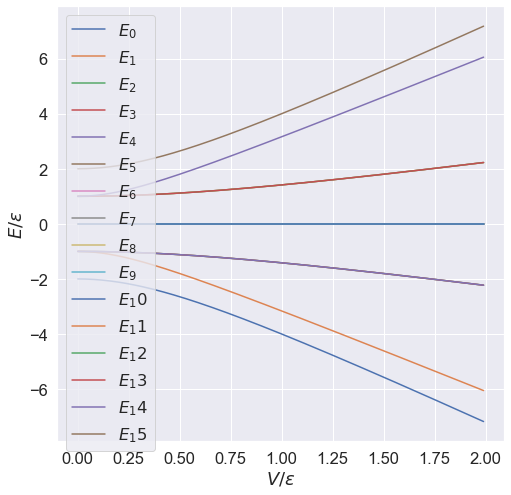

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(len(eigvals_ana[0])):
    axs.plot(v_vals_ana, eigvals_ana[:, i], label=f'$E_{i}$')
axs.set_xlabel(r'$V/\epsilon$')
axs.set_ylabel(r'$E/\epsilon$')
axs.legend(loc = 'upper left')
plt.show()

## Finding the unitary matrices which rotate the measurement basis

In [6]:
Z = np.array([[1, 0], [0, -1]])
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
H = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])
S = np.array([[1, 0], [0, 1j]])
CNOT01 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
CNOT10 = np.array([[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0]])
SWAP = np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])


# Z1 = Z I I I 
ZIII = np.kron(Z, np.kron(I, np.kron(I, I))) # this is the measurement basis
IZII = np.kron(I, np.kron(Z, np.kron(I, I)))
IIZI = np.kron(I, np.kron(I, np.kron(Z, I)))
IIIZ = np.kron(I, np.kron(I, np.kron(I, Z)))
ZIZI = np.kron(Z, np.kron(I, np.kron(Z, I)))

U_IZII = np.kron(np.kron(I, I)@SWAP, np.kron(I, I))
print('IZII:')
print(np.sum(np.abs(IZII - U_IZII.conj().T @ ZIII @ U_IZII)))

U_IIZI = U_IZII@np.kron(I, np.kron(np.kron(I, I)@SWAP, I))
print('IIZI:')
print(np.sum(np.abs(IIZI - U_IIZI.conj().T @ ZIII @ U_IIZI)))

U_IIIZ = U_IIZI@np.kron(I, np.kron(I, np.kron(I, I)@SWAP))
print('IIIZ:')
print(np.sum(np.abs(IIIZ - U_IIIZ.conj().T @ ZIII @ U_IIIZ)))

U_ZIZI = np.kron(CNOT10, np.kron(I, I))@np.kron(I, np.kron(SWAP@np.kron(I, I), I))
print('ZIZI:')
print(np.sum(np.abs(ZIZI - U_ZIZI.conj().T @ ZIII @ U_ZIZI)))

XXII = np.kron(X, np.kron(X, np.kron(I, I)))
XIXI = np.kron(X, np.kron(I, np.kron(X, I)))
XIIX = np.kron(X, np.kron(I, np.kron(I, X)))
IXXI = np.kron(I, np.kron(X, np.kron(X, I)))
IXIX = np.kron(I, np.kron(X, np.kron(I, X)))
IIXX = np.kron(I, np.kron(I, np.kron(X, X)))

U_XX = CNOT10@np.kron(H, H)

U_XI = np.kron(H, I)
U_IX = U_XI@SWAP
# U_XXII = np.kron(CNOT10@np.kron(H, H), np.kron(I, I))
U_XXII = np.kron(U_XX, np.kron(I, I))
print('XXII:')
print(np.sum(np.abs(XXII - U_XXII.conj().T @ ZIII @ U_XXII)))

U_XIXI = U_ZIZI@np.kron(U_XI, U_XI)
print('XIXI:')
print(np.sum(np.abs(XIXI - U_XIXI.conj().T @ ZIII @ U_XIXI)))

U_XIIX = U_ZIZI@np.kron(U_XI, U_IX)
print('XIXI:')
print(np.sum(np.abs(XIIX - U_XIIX.conj().T @ ZIII @ U_XIIX)))

U_IXXI = U_ZIZI@np.kron(U_IX, U_XI)
print('IXXI:')
print(np.sum(np.abs(IXXI - U_IXXI.conj().T @ ZIII @ U_IXXI)))

U_IXIX = U_ZIZI@np.kron(U_IX, U_IX)
print('IXIX:')
print(np.sum(np.abs(IXIX - U_IXIX.conj().T @ ZIII @ U_IXIX)))

U_IIXX = U_IIZI@np.kron(I, np.kron(I, U_XX))
print('IIXX:')
print(np.sum(np.abs(IIXX - U_IIXX.conj().T @ ZIII @ U_IIXX)))

YYII = np.kron(Y, np.kron(Y, np.kron(I, I)))
YIYI = np.kron(Y, np.kron(I, np.kron(Y, I)))
YIIY = np.kron(Y, np.kron(I, np.kron(I, Y)))
IYYI = np.kron(I, np.kron(Y, np.kron(Y, I)))
IYIY = np.kron(I, np.kron(Y, np.kron(I, Y)))
IIYY = np.kron(I, np.kron(I, np.kron(Y, Y)))

Sdag = S.conj().T
U_YY = CNOT10@np.kron(H@Sdag, H@Sdag)
U_YI = np.kron(H@Sdag, I)
U_IY = U_YI@SWAP
U_YYII = np.kron(U_YY, np.kron(I, I))
print('YYII:')
print(np.sum(np.abs(YYII - U_YYII.conj().T @ ZIII @ U_YYII)))

U_YIYI = U_ZIZI@np.kron(U_YI, U_YI)
print('YIYI:')
print(np.sum(np.abs(YIYI - U_YIYI.conj().T @ ZIII @ U_YIYI)))

U_YIIY = U_ZIZI@np.kron(U_YI, U_IY)
print('YIYI:')
print(np.sum(np.abs(YIIY - U_YIIY.conj().T @ ZIII @ U_YIIY)))

U_IYYI = U_ZIZI@np.kron(U_IY, U_YI)
print('IYYI:')
print(np.sum(np.abs(IYYI - U_IYYI.conj().T @ ZIII @ U_IYYI)))

U_IYIY = U_ZIZI@np.kron(U_IY, U_IY)
print('IYIY:')
print(np.sum(np.abs(IYIY - U_IYIY.conj().T @ ZIII @ U_IYIY)))

U_IIYY = U_IIZI@np.kron(I, np.kron(I, U_YY))
print('IIYY:')
print(np.sum(np.abs(IIYY - U_IIYY.conj().T @ ZIII @ U_IIYY)))


IZII:
0
IIZI:
0
IIIZ:
0
ZIZI:
0
XXII:
7.105427357601002e-15
XIXI:
7.105427357601002e-15
XIXI:
7.105427357601002e-15
IXXI:
7.105427357601002e-15
IXIX:
7.105427357601002e-15
IIXX:
7.105427357601002e-15
YYII:
7.105427357601002e-15
YIYI:
7.105427357601002e-15
YIYI:
7.105427357601002e-15
IYYI:
7.105427357601002e-15
IYIY:
7.105427357601002e-15
IIYY:
7.105427357601002e-15


In [36]:
toffoli = np.eye(8)
toffoli[6:8, 6:8] = np.array([[0, 1], [1, 0]])
print('toffoli:', toffoli)

toffoli: [[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


In [7]:
def prepare_state(angles, target = None):
    # # angles has the form (theta0, phi0, theta1, phi1, ...)
    qubit = Four_qubit()
    I, X, Y, CNOT10, CNOT01 = qubit.I, qubit.X, qubit.Y, qubit.CNOT10, qubit.CNOT01
    init_state = np.zeros(16)
    init_state[0] = 1
    rotations = []
    for i in range(0, len(angles)-1, 2):
        theta, phi = angles[i], angles[i+1]
        Rx = np.cos(theta/2) * I - 1j * np.sin(theta/2) * X
        Ry = np.cos(phi/2) * I - 1j * np.sin(phi/2) * Y
        rotations.append(Ry@Rx)
    
    rotate = np.kron(rotations[0], np.kron(rotations[1], np.kron(rotations[2], rotations[3])))
    state = rotate @ init_state
    state = np.kron(I, np.kron(I, CNOT10))@state 
    state = np.kron(I, np.kron(CNOT10, I))@state 
    state = np.kron(CNOT10, np.kron(I, I))@state 
    # entangle = np.kron(CNOT10, CNOT01)
    # state = entangle @ state
    # entangle = np.kron(I, toffoli)
    # state = entangle @ state
    # # rotate qubits
    
    if target is not None:
        state = target
    qubit.set_state(state)
    return qubit.state

def get_energy(angles, v, number_shots, target = None):
    init_state = prepare_state(angles, target)
    qubit = Four_qubit()
    SWAP, CNOT10, H, S, I = qubit.SWAP, qubit.CNOT10, qubit.H, qubit.S, qubit.I
    Sdag = S.conj().T

    measures = []
    unitaries = []
    U_ZIII = np.kron(I, np.kron(I, np.kron(I, I)))
    unitaries.append(U_ZIII)
    U_IZII = np.kron(np.kron(I, I)@SWAP, np.kron(I, I))
    unitaries.append(U_IZII)
    U_IIZI = U_IZII@np.kron(I, np.kron(np.kron(I, I)@SWAP, I))
    unitaries.append(U_IIZI)
    U_IIIZ = U_IIZI@np.kron(I, np.kron(I, np.kron(I, I)@SWAP))
    unitaries.append(U_IIIZ)

    U_ZIZI = np.kron(CNOT10, np.kron(I, I))@np.kron(I, np.kron(SWAP@np.kron(I, I), I))
    
    U_XX = CNOT10@np.kron(H, H)
    U_XI = np.kron(H, I)
    U_IX = U_XI@SWAP
    U_XXII = np.kron(U_XX, np.kron(I, I))
    unitaries.append(U_XXII)
    U_XIXI = U_ZIZI@np.kron(U_XI, U_XI)
    unitaries.append(U_XIXI)
    U_XIIX = U_ZIZI@np.kron(U_XI, U_IX)
    unitaries.append(U_XIIX)
    U_IXXI = U_ZIZI@np.kron(U_IX, U_XI)
    unitaries.append(U_IXXI)
    U_IXIX = U_ZIZI@np.kron(U_IX, U_IX)
    unitaries.append(U_IXIX)
    U_IIXX = U_IIZI@np.kron(I, np.kron(I, U_XX))
    unitaries.append(U_IIXX)

    U_YY = CNOT10@np.kron(H@Sdag, H@Sdag)
    U_YI = np.kron(H@Sdag, I)
    U_IY = U_YI@SWAP
    U_YYII = np.kron(U_YY, np.kron(I, I))
    unitaries.append(U_YYII)
    U_YIYI = U_ZIZI@np.kron(U_YI, U_YI)
    unitaries.append(U_YIYI)
    U_YIIY = U_ZIZI@np.kron(U_YI, U_IY)
    unitaries.append(U_YIIY)
    U_IYYI = U_ZIZI@np.kron(U_IY, U_YI)
    unitaries.append(U_IYYI)
    U_IYIY = U_ZIZI@np.kron(U_IY, U_IY)
    unitaries.append(U_IYIY)
    U_IIYY = U_IIZI@np.kron(np.kron(I, I), U_YY)
    unitaries.append(U_IIYY)

    for U in unitaries:
        qubit.set_state(init_state)
        qubit.state = U@qubit.state
        measure = qubit.measure(number_shots)
        measures.append(measure)
    
    exp_vals = np.zeros(len(measures)) 
    consts_z = 0.5*np.ones(4)
    consts_x = -0.5*v*np.ones(6)
    consts_y = 0.5*v*np.ones(6)
    constants = np.concatenate((consts_z, consts_x, consts_y))
    for index in range(len(exp_vals)):
        counts = [len(np.where(measures[index] == i)[0]) for i in range(16)] 
        for outcome, count in enumerate(counts):
            if outcome <= 7:
                exp_vals[index] += count #the first 8 outcomes correspond to 0 in the first qubit
            elif outcome > 7:
                exp_vals[index] -= count #the last 8 outcomes correspond to 1 in the first qubit
    exp_val = np.sum(constants * exp_vals) / number_shots
    return exp_val


In [8]:
qubit = Four_qubit()
SWAP, CNOT10, H, S, I = qubit.SWAP, qubit.CNOT10, qubit.H, qubit.S, qubit.I
Sdag = S.conj().T


measures = []
unitaries = []
U_ZIII = np.kron(I, np.kron(I, np.kron(I, I)))
unitaries.append(U_ZIII)
U_IZII = np.kron(np.kron(I, I)@SWAP, np.kron(I, I))
unitaries.append(U_IZII)
U_IIZI = U_IZII@np.kron(I, np.kron(np.kron(I, I)@SWAP, I))
unitaries.append(U_IIZI)
U_IIIZ = U_IIZI@np.kron(I, np.kron(I, np.kron(I, I)@SWAP))
unitaries.append(U_IIIZ)

U_ZIZI = np.kron(CNOT10, np.kron(I, I))@np.kron(I, np.kron(SWAP@np.kron(I, I), I))

U_XX = CNOT10@np.kron(H, H)
U_XI = np.kron(H, I)
U_IX = U_XI@SWAP
U_XXII = np.kron(U_XX, np.kron(I, I))
unitaries.append(U_XXII)
U_XIXI = U_ZIZI@np.kron(U_XI, U_XI)
unitaries.append(U_XIXI)
U_XIIX = U_ZIZI@np.kron(U_XI, U_IX)
unitaries.append(U_XIIX)
U_IXXI = U_ZIZI@np.kron(U_IX, U_XI)
unitaries.append(U_IXXI)
U_IXIX = U_ZIZI@np.kron(U_IX, U_IX)
unitaries.append(U_IXIX)
U_IIXX = U_IIZI@np.kron(I, np.kron(I, U_XX))
unitaries.append(U_IIXX)

U_YY = CNOT10@np.kron(H@Sdag, H@Sdag)
U_YI = np.kron(H@Sdag, I)
U_IY = U_YI@SWAP
U_YYII = np.kron(U_YY, np.kron(I, I))
unitaries.append(U_YYII)
U_YIYI = U_ZIZI@np.kron(U_YI, U_YI)
unitaries.append(U_YIYI)
U_YIIY = U_ZIZI@np.kron(U_YI, U_IY)
unitaries.append(U_YIIY)
U_IYYI = U_ZIZI@np.kron(U_IY, U_YI)
unitaries.append(U_IYYI)
U_IYIY = U_ZIZI@np.kron(U_IY, U_IY)
unitaries.append(U_IYIY)
U_IIYY = U_IIZI@np.kron(np.kron(I, I), U_YY)
unitaries.append(U_IIYY)

In [9]:
def prepare_state_test(angles, target = None):
    # # angles has the form (theta0, phi0, theta1, phi1, ...)
    qubit = Four_qubit()
    I, X, Y, CNOT10, CNOT01 = qubit.I, qubit.X, qubit.Y, qubit.CNOT10, qubit.CNOT01
    state = np.zeros(16)
    state[0] = 1
    #split the angles list into batches of 8
    angles_batches = [angles[i:i+8] for i in range(0, len(angles), 8)]
    rotations = []
    for angles in angles_batches:
        for i in range(0, len(angles)-1, 2):
            theta, phi = angles[i], angles[i+1]
            Rx = np.cos(theta/2) * I - 1j * np.sin(theta/2) * X
            Ry = np.cos(phi/2) * I - 1j * np.sin(phi/2) * Y
            rotations.append(Ry@Rx)
    print(len(rotations))
    for _ in range(0, len(rotations), 4):    
        rotate = np.kron(rotations[i], np.kron(rotations[i+1], np.kron(rotations[i+2], rotations[i+3])))
        state = rotate @ state
        state = np.kron(I, np.kron(I, CNOT10))@state 
        state = np.kron(I, np.kron(CNOT10, I))@state 
        state = np.kron(CNOT10, np.kron(I, I))@state 
    
    if target is not None:
        state = target
    qubit.set_state(state)
    return qubit.state

def get_energy_test(angles, v, number_shots, unitaries, target = None):
    init_state = prepare_state(angles, target)
    measures = np.zeros((len(unitaries), number_shots))
    for index, U in enumerate(unitaries):
        qubit.set_state(init_state)
        qubit.state = U@qubit.state
        measure = qubit.measure(number_shots)
        measures[index] = measure
    
    exp_vals = np.zeros(len(measures)) 
    consts_z = 0.5*np.ones(4)
    consts_x = -0.5*v*np.ones(6)
    consts_y = 0.5*v*np.ones(6)
    constants = np.concatenate((consts_z, consts_x, consts_y))
    for index in range(len(exp_vals)):
        counts = [len(np.where(measures[index] == i)[0]) for i in range(16)] 
        for outcome, count in enumerate(counts):
            if outcome <= 7:
                exp_vals[index] += count #the first 8 outcomes correspond to 0 in the first qubit
            elif outcome > 7:
                exp_vals[index] -= count #the last 8 outcomes correspond to 1 in the first qubit
    exp_val = np.sum(constants * exp_vals) / number_shots
    return exp_val


In [10]:
def get_gradient(angles, v, number_shots, unitaries):
    grad = np.zeros(len(angles))
    for index, angle in enumerate(angles):
        tmp = angles.copy()
        tmp[index] += np.pi/2
        energy_plus = get_energy_test(tmp, v, number_shots, unitaries)
        tmp[index] -= np.pi
        energy_minus = get_energy_test(tmp, v, number_shots, unitaries)
        grad[index] = (energy_plus - energy_minus) / 2
    return grad

  0%|                                                                                                                                                        | 0/1 [00:00<?, ?it/s]/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.54s/it]

   direc: array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])
     fun: -3.248
 message: 'Optimization terminated successfully.'
    nfev: 3754
     nit: 3
  status: 0
 success: True
       x: array([ 3.18438359e+00,  2.03181836e+00,  3.36922423e+00,  4.56192851e+00,
       -2.00206007e-02,  5.41823601e+00,  5.58745350e-02,  2.00191512e+00,
        3.11255917e+00,  2.51288127e+00,  1.13748050e+00,  9.25789176e+00,
        3.33831796e+00,  9.45365201e+00,  7.43562206e-01,  4.22614376e+00,
       -2.08143520e+00,  6.59431225e+00,  5.94520454e+00,  2.02977982e+00,
        4.05510034e+00,  5.35968709e+00,  2.94544236e+00,  6.62781691e+00,
       -1.52588147e+00,  7.03819168e+00,  2.98907552e+00,  2.09278213e+00,
        7.07303581e+00,  5.55123258e+00,  8.89836278e+00,  2.59503630e+00,
        5.12778259

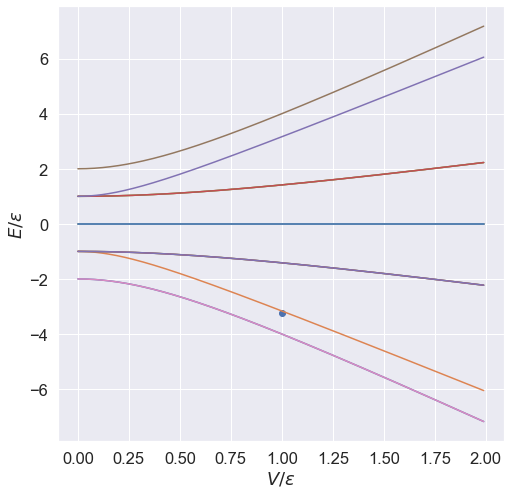

In [11]:
from scipy.optimize import minimize
number_shots = 1_000
v_vals = np.linspace(1.0, 1.1, 1) # only 2.0
# target = eigvecs[:, 0] # ground state
min_energy_scipy = np.zeros(len(v_vals))
for index, v in enumerate(tqdm(v_vals)):
    angles_start = np.random.uniform(low = 0, high = 2*np.pi, size = 5*8)
    res = minimize(fun = get_energy_test, jac = get_gradient, x0 = angles_start, args = (v, number_shots, unitaries), method = 'Powell', options = {'maxiter': 10000}, tol = 1e-8)
    min_energy_scipy[index] = res.fun
    print(res)

fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(len(eigvals_ana[0])):
    axs.plot(v_vals_ana, eigvals_ana[:, i], label=f'$E_{i}$')
axs.plot(v_vals_ana, eigvals_ana[:, 0], label=f'$E_{i}$')
axs.set_xlabel(r'$V/\epsilon$')
axs.scatter(v_vals, min_energy_scipy, label='VQE Energy Scipy', marker='o')
axs.set_ylabel(r'$E/\epsilon$')
# axs.legend(loc = 'upper left')
plt.show()


In [13]:
def get_gradient(angles, v, number_shots):
    grad = np.zeros(len(angles))
    for index, angle in enumerate(angles):
        tmp = angles.copy()
        tmp[index] += np.pi/2
        energy_plus = get_energy_test(tmp, v, number_shots)
        tmp[index] -= np.pi
        energy_minus = get_energy_test(tmp, v, number_shots)
        grad[index] = (energy_plus - energy_minus) / 2
    return grad

In [14]:
def minimize_energy(v, number_shots, angles_0, learning_rate, max_epochs):
    angles = angles_0 
    epoch = 0
    delta_energy = 1
    energy = get_energy(angles, v, number_shots)
    energy_iter = []
    grad = get_gradient(angles_0, v, number_shots)
    while (epoch < max_epochs) and (np.linalg.norm(grad) > 1e-5):
        grad = get_gradient(angles, v, number_shots)
        angles -= learning_rate*grad 
        new_energy = get_energy(angles, v, number_shots)
        energy_iter.append(new_energy)  
        delta_energy = np.abs(new_energy - energy)
        energy = new_energy
        epoch += 1
    return angles, epoch, (epoch < max_epochs), energy, delta_energy, grad, energy_iter

number_shots = 1_000
learning_rate = 0.01
max_epochs = 2000
angles_0 = np.random.uniform(0, np.pi, 8)
v = 1.0
angles, epoch, success, energy, delta_energy, grad, energy_iter = minimize_energy(v, number_shots, angles_0, learning_rate, max_epochs)
print(angles, epoch, success, energy, delta_energy, np.linalg.norm(grad))
plt.plot(energy_iter)

TypeError: get_energy_test() missing 1 required positional argument: 'unitaries'

 20%|████████████████████████████▊                                                                                                                   | 1/5 [00:02<00:09,  2.45s/it]

Optimization terminated successfully.


 40%|█████████████████████████████████████████████████████████▌                                                                                      | 2/5 [00:03<00:05,  1.77s/it]

Optimization terminated successfully.


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 3/5 [00:05<00:03,  1.82s/it]

Optimization terminated successfully.


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4/5 [00:07<00:01,  1.77s/it]

Optimization terminated successfully.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.77s/it]

Optimization terminated successfully.


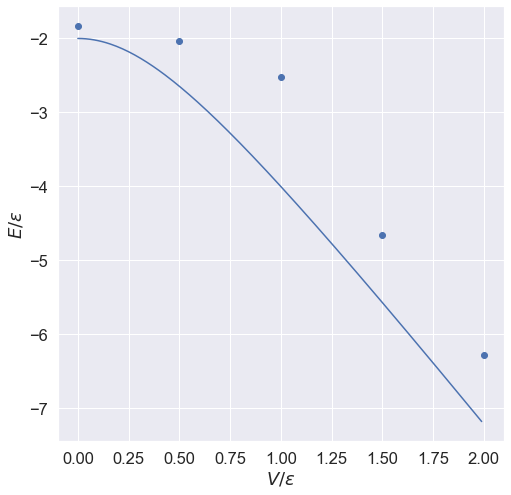

In [15]:
from scipy.optimize import minimize
number_shots = 1_000
v_vals = np.linspace(0, 2.0, 5) # only 2.0
# target = eigvecs[:, 0] # ground state
min_energy_scipy = np.zeros(len(v_vals))
for index, v in enumerate(tqdm(v_vals)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 8)
    res = minimize(fun = get_energy, x0 = angles_start, args = (v, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_scipy[index] = res.fun
    print(res.message)

fig, axs = plt.subplots(1, 1, figsize=(8, 8))
# for i in range(len(eigvals_ana[0])):
#     axs.plot(v_vals_ana, eigvals_ana[:, i], label=f'$E_{i}$')
axs.plot(v_vals_ana, eigvals_ana[:, 0], label=f'$E_{i}$')
axs.set_xlabel(r'$V/\epsilon$')
axs.scatter(v_vals, min_energy_scipy, label='VQE Energy Scipy', marker='o')
axs.set_ylabel(r'$E/\epsilon$')
# axs.legend(loc = 'upper left')
plt.show()


100%|██████████| 10/10 [00:00<00:00, 66.50it/s]


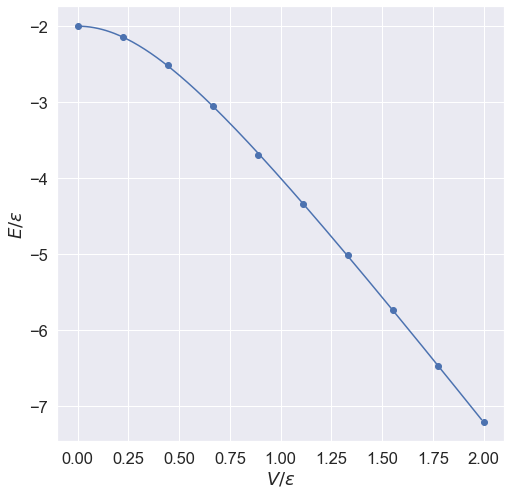

In [61]:
number_shots = 10_000
v_vals = np.linspace(0, 2.0, 10) # only 2.0
# target = eigvecs[:, 0] # ground state
min_energy_target = np.zeros(len(v_vals))
for index, v in enumerate(tqdm(v_vals)):
    H = Hamiltonian(v)
    eigvals, eigvecs = np.linalg.eigh(H)
    permute = np.argsort(eigvals)
    eigvals = eigvals[permute]
    eigvecs = eigvecs[:, permute]
    target = eigvecs[:, 0] # ground state
    angles = np.random.uniform(low = 0, high = np.pi, size = 8)
    min_energy_target[index] = get_energy(angles, v, number_shots, target)
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
# for i in range(len(eigvals_ana[0])):
#     axs.plot(v_vals_ana, eigvals_ana[:, i], label=f'$E_{i}$')
axs.plot(v_vals_ana, eigvals_ana[:, 0], label=f'$E_{i}$')
axs.set_xlabel(r'$V/\epsilon$')
axs.scatter(v_vals, min_energy_target, label='VQE Energy Target', marker='o')
axs.set_ylabel(r'$E/\epsilon$')
# axs.legend(loc = 'upper left')
plt.show()


In [31]:
qb = Two_qubit()

cnot10, cnot01, swap = qb.CNOT10, qb.CNOT01, qb.SWAP
I = np.eye(2)
tmp = np.kron(cnot01, I) @ np.kron(swap, I)
print(tmp)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]
